# **Face Recognition**

In [1]:
# mount my Google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# 1. Setup

## 1.1 Install Python Libraries

In [2]:
!pip install --upgrade pip
!pip install tensorflow -q # for deep learning
!pip install opencv-python -q # for image processing
!pip install matplotlib -q # for plotting
!pip install mtcnn # for face detection
!pip install pydot -q # for plotting model
!pip install keras-tuner -q # for hyperparameter tuning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


## 1.2 Import Python Libraries

In [3]:
from pathlib import Path
import shutil

import numpy as np
import random
import time

# Visualization
from matplotlib import pyplot as plt
import cv2

# Tensorflow
import tensorflow as tf


from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras import utils
from tensorflow.keras import preprocessing
from tensorflow.keras.applications import resnet

# rom tensorflow.keras.utils import *
import tensorflow_datasets as tfds

import mtcnn
from mtcnn.mtcnn import MTCNN  # face detection pre-trained model

import keras_tuner as kt  # for models hyperparameter tuning

## 1.3 Project Configurations

In [4]:
# Files and Paths
PROJECT_PATH = Path(".", "drive", "MyDrive", "Project")

ORIGINAL_DS_PATH = Path(
    PROJECT_PATH,
    "dataset",
    "downloads",
    "extracted",
    "TAR_GZ.vis-www.cs.umass.edu_lfw_lfwBV99nGMtc3Dm-0r8dGjUD5cMNKgNTG9Q_-xj9ajVNsA.tgz",
    "lfw",
)
SELECTED_DS_PATH = Path(PROJECT_PATH,  "selected_ds")
CROPPED_DS_PATH = Path(PROJECT_PATH, "cropped_ds")

CLASSIFICATION_MODEL_FILE = Path(
    PROJECT_PATH, "art-project", "classification_model.keras"
)

In [5]:
# Data Configuration
SAMPLES_PER_PERSON = 60  # Minimum number of faces per person

TRAINING_PERCENTAGE = 0.6
VALIDATION_PERCENTAGE = 0.2
TEST_PERCENTAGE = 0.2

BATCH_SIZE = 32
DROPOUT_RATE = 0.3
LEARNING_RATE = 0.0001
TRAINING_EPOCHS = 10

ORIGINAL_IMAGE_SIZE = (250, 250, 3)  # (height, width, channels)
IMAGE_SIZE = (200, 200, 3)  # (height, width, channels)

FACE_DETECTION_BOX_SCALE = 1.1
WITH_AUGMENTATION = False  # Collision with resnet.preprocess_input

In [6]:
RANDOM_SEED = 2024
tf.random.set_seed(RANDOM_SEED)

In [7]:
# Some Checkers
assert TRAINING_PERCENTAGE + VALIDATION_PERCENTAGE + TEST_PERCENTAGE == 1.0
assert ORIGINAL_IMAGE_SIZE == (250, 250, 3)
assert IMAGE_SIZE == (200, 200, 3)

## 1.4 GPU Configuration
❗Please check that GPU enabled




In [8]:
gpus = tf.config.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
gpu_name = tf.test.gpu_device_name()
print(gpu_name)

/device:GPU:0


# 2. Visualization functions



In [9]:
# Show one image with label
def show_sample(image, label="Sample"):
    # Squeeze image with expanded dimentionss
    if len(image.shape) == 4:
        image = tf.squeeze(image, axis=0)

    height, width, channels = image.shape
    plt.figure(figsize=(4, 4))
    if channels == 1:
        plt.imshow(image, cmap="gray")
    else:
        plt.imshow(image)
    plt.title(f"{label} shape {image.shape}", fontsize=10)
    plt.axis("off")

    plt.show()

In [10]:
# Return image with bounding boxes on it
def mark_bounding_boxes(image: np.array, bboxs):
    #   +------------------+
    #   |                  |
    # height               |
    #   |                  |
    #  (xy)---- width -----+
    for bbox in bboxs:
        x, y, w, h = bbox["box"]
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        for keypoint in ["left_eye", "right_eye", "nose", "mouth_left", "mouth_right"]:
            cv2.circle(
                image,
                (bbox["keypoints"][keypoint]),
                1,
                (0, 255, 255),
                2,
            )
    return image

In [11]:
# Show history of training: plots of accuracy, loss, etc..
def show_history(history):
    epochs = range(1, TRAINING_EPOCHS + 1)

    num_of_metrics = max(2, len(history.keys()) // 2)
    fig, ax = plt.subplots(1, num_of_metrics, figsize=(15, 5))
    for i in range(num_of_metrics):
        ax[i].axis("off")

    for i, metric in enumerate(history.keys()):
        if "val_" in metric:
            continue
        ax[i].plot(epochs, history[metric], label=f"Training {metric}")
        ax[i].plot(epochs, history[f"val_{metric}"], label=f"Validation {metric}")
        ax[i].set_title(f"Metric: {metric}")
        ax[i].set_xlabel("Epochs")
        ax[i].set_ylabel("Value")
        ax[i].grid()

        ax[i].legend()
        ax[i].axis("on")
    plt.show()

# 3. Data Preprocessing

## 3.1 Download LFW Dataset

In [12]:
# Download dataset
tfds.load(
    name="lfw",
    data_dir=Path(PROJECT_PATH, "dataset"),
    split="all"
)

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(250, 250, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.string, name=None)}>

In [13]:
# Create temporary DataSet object with all pairs (sample, label)
ds = preprocessing.image_dataset_from_directory(
    str(ORIGINAL_DS_PATH),
    label_mode="int", # labels are numbers (label id)
    batch_size=None,
    image_size=(250, 250),
    shuffle=True,
    seed=RANDOM_SEED,
)

Found 13233 files belonging to 5749 classes.


## 3.2 Dataset Exploring

In [14]:
# Image size
H, W, C = ds.element_spec[0].shape
print(f"Original Image Size {H}x{W}x{C}")

# Number of features
num_of_features = H * W * C
print(f"Original Image Features(Pixels) {num_of_features}")

# Number of samples
num_of_samples = ds.cardinality().numpy()
print(f"Number of Samples {num_of_samples}")

# Number of classes
num_of_classes = len(ds.class_names)
print(f"Number of Classes {num_of_classes}")

# Print some files
ds.file_paths[:5]

Original Image Size 250x250x3
Original Image Features(Pixels) 187500
Number of Samples 13233
Number of Classes 5749


['drive/MyDrive/Project/dataset/downloads/extracted/TAR_GZ.vis-www.cs.umass.edu_lfw_lfwBV99nGMtc3Dm-0r8dGjUD5cMNKgNTG9Q_-xj9ajVNsA.tgz/lfw/Stan_Heath/Stan_Heath_0001.jpg',
 'drive/MyDrive/Project/dataset/downloads/extracted/TAR_GZ.vis-www.cs.umass.edu_lfw_lfwBV99nGMtc3Dm-0r8dGjUD5cMNKgNTG9Q_-xj9ajVNsA.tgz/lfw/Tom_Crean/Tom_Crean_0001.jpg',
 'drive/MyDrive/Project/dataset/downloads/extracted/TAR_GZ.vis-www.cs.umass.edu_lfw_lfwBV99nGMtc3Dm-0r8dGjUD5cMNKgNTG9Q_-xj9ajVNsA.tgz/lfw/Franz_Fischler/Franz_Fischler_0001.jpg',
 'drive/MyDrive/Project/dataset/downloads/extracted/TAR_GZ.vis-www.cs.umass.edu_lfw_lfwBV99nGMtc3Dm-0r8dGjUD5cMNKgNTG9Q_-xj9ajVNsA.tgz/lfw/Tony_Blair/Tony_Blair_0065.jpg',
 'drive/MyDrive/Project/dataset/downloads/extracted/TAR_GZ.vis-www.cs.umass.edu_lfw_lfwBV99nGMtc3Dm-0r8dGjUD5cMNKgNTG9Q_-xj9ajVNsA.tgz/lfw/Dereck_Whittenburg/Dereck_Whittenburg_0001.jpg']

In [15]:
# Build folder of selebrities with number of samples >= NUM_OF_FACES_PER_PERSON
if not SELECTED_DS_PATH.exists():
  print(f"{'Name':<25} {'Samples':<10}")
  print(f"{'-'*25} {'-'*10}")
  SELECTED_DS_PATH.mkdir(exist_ok=True)  # Make selected dataset directory

  for item in ORIGINAL_DS_PATH.iterdir():
      if item.is_dir():
          label_name = item.name
          files_in_folder = sorted(list(item.glob("*.jpg")))
          num_files_in_folder = len(files_in_folder)
          if num_files_in_folder >= SAMPLES_PER_PERSON:
              # Create folder fot the seleb in SELECTED_DS_PATH
              selected_label_folder = Path(SELECTED_DS_PATH, label_name)
              selected_label_folder.mkdir(exist_ok=True)
              # Copy SAMPLES_PER_PERSON
              for file_name in files_in_folder[:SAMPLES_PER_PERSON]:
                  selected_file_path = Path(selected_label_folder, file_name.name)
                  shutil.copyfile(file_name, selected_file_path)
              print(f"{label_name:<25} {SAMPLES_PER_PERSON}")

Name                      Samples   
------------------------- ----------
Gerhard_Schroeder         60
George_W_Bush             60
Donald_Rumsfeld           60
Junichiro_Koizumi         60
Tony_Blair                60
Ariel_Sharon              60
Colin_Powell              60
Hugo_Chavez               60


In [16]:
# Create DataSet object with selected pairs (sample, label)
ds = preprocessing.image_dataset_from_directory(
    str(SELECTED_DS_PATH),
    label_mode="int",
    batch_size=None,
    image_size=(250, 250),
    shuffle=True,
    seed=RANDOM_SEED,
)

Found 480 files belonging to 8 classes.


In [17]:
print("Selected Dataset size:")
# Number of samples
num_of_samples = ds.cardinality().numpy()
print(f"Number of Samples {num_of_samples}")

# Number of classes
num_of_classes = len(ds.class_names)
print(f"Number of Classes {num_of_classes}")

ds_class_names = ds.class_names
# Classes
ds_class_names

Selected Dataset size:
Number of Samples 480
Number of Classes 8


['Ariel_Sharon',
 'Colin_Powell',
 'Donald_Rumsfeld',
 'George_W_Bush',
 'Gerhard_Schroeder',
 'Hugo_Chavez',
 'Junichiro_Koizumi',
 'Tony_Blair']

## 3.3 Offline Preprocessing

### 3.3.1 Face Detection

In [18]:
# The input to MTCNN detect_faces() is numpy array.
# We can't to call this function in Dataset.map() directly (works on numpy array).
face_detector = MTCNN()

In [19]:
# Face detection with MTCNN and image cropping according to
# the detection
def face_detection(image, show=False):
    # -- Find MTCNN boxes
    bounding_boxes = face_detector.detect_faces(image)

    # If faces found
    if len(bounding_boxes) > 0:
        if show == True:
            image_with_boxes = mark_bounding_boxes(image.copy(), bounding_boxes)

        # -- Choose Single Box closest to the center
        bounding_box = select_single_bounding_box(
            bboxes=bounding_boxes, image_size=image.shape
        )

        if show == True:
            image_with_box = mark_bounding_boxes(image.copy(), [bounding_box])

        # -- Crop the face
        if bounding_box:
            x, y, w, h = bounding_box["box"]
            image = image[y : y + h, x : x + w]

        if show == True:
            show_sample(image_with_boxes, "1. Detected Faces")
            show_sample(image_with_box, "2. Detected Face")
            show_sample(image, "3. Cropped Face")
    else:
        print(f"No face detected.")

    return image

In [20]:
# Find the major single face closest to the center
def select_single_bounding_box(
    bboxes, image_size=ORIGINAL_IMAGE_SIZE, scale=FACE_DETECTION_BOX_SCALE
):
    if len(bboxes) == 0:
        return None
    # Choose face with its nose closer to the center
    # Calculate the distance from the center of the image
    w, h, c = image_size
    center_x = w / 2
    center_y = h / 2
    distances = []
    for i in range(len(bboxes)):
        x, y, w, h = bboxes[i]["box"]

        # Scale the bounding box (squared)
        w_scaled = int(w * scale)
        h_scaled = int(h * scale)

        hw_diff = max(0, h_scaled - w_scaled)
        w_scaled = w_scaled + hw_diff

        x_scaled = max(0, int(x - (w_scaled - w) / 2))
        y_scaled = max(0, int(y - (h_scaled - h) / 2))

        bboxes[i]["box"] = [x_scaled, y_scaled, w_scaled, h_scaled]

        nose_x, nose_y = bboxes[i]["keypoints"]["nose"]
        distances.append(np.sqrt((center_x - nose_x) ** 2 + (center_y - nose_y) ** 2))

    closest_face_index = np.argmin(distances)
    return bboxes[closest_face_index]

### 3.3.2 Image Resize

In [21]:
# Image resize
def image_resize(image, image_size=IMAGE_SIZE):
    height, width, channels = image_size

    # Resize the image
    image = tf.image.resize(image, [height, width])
    image = tf.cast(image, dtype=tf.uint8)
    return image

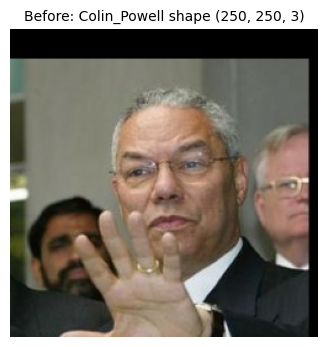

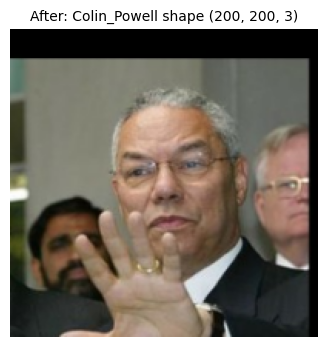

In [22]:
#[DEBUG] Test image resizing
_file_name = Path(SELECTED_DS_PATH, "Colin_Powell", "Colin_Powell_0010.jpg")
_img_bytes = tf.io.read_file(str(_file_name))
_image = tf.image.decode_jpeg(_img_bytes, channels=C)

show_sample(_image, "Before: Colin_Powell")
_image = image_resize(_image)
show_sample(_image, "After: Colin_Powell")

### 3.3.3 Put all offline preprocessing together

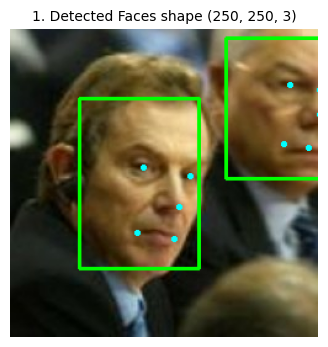

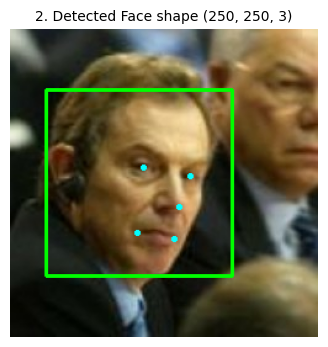

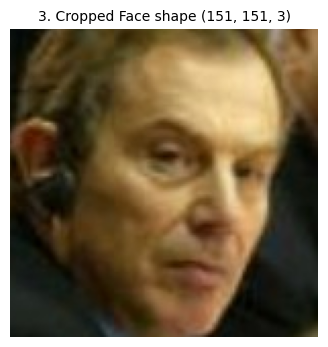

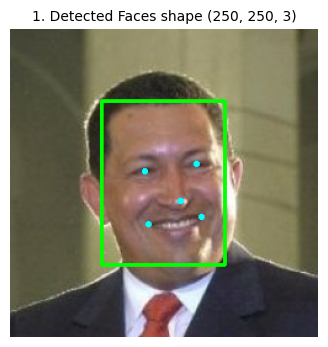

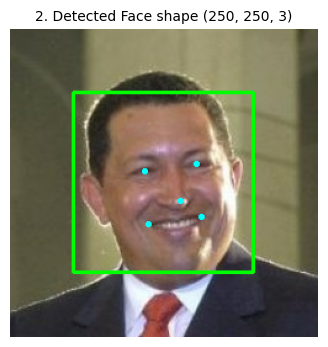

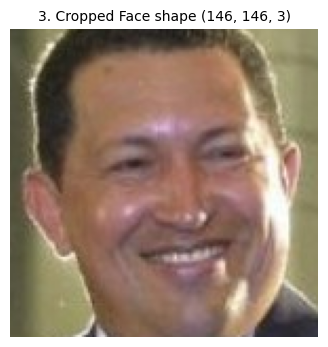

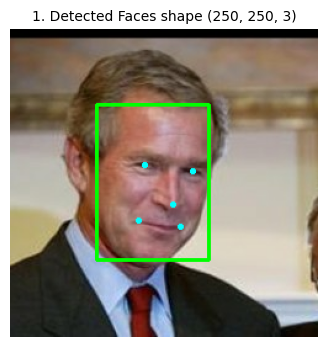

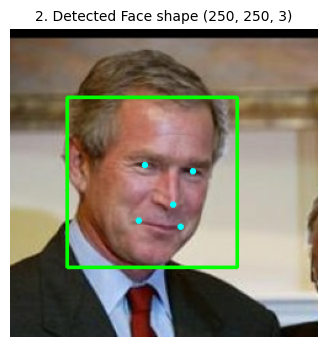

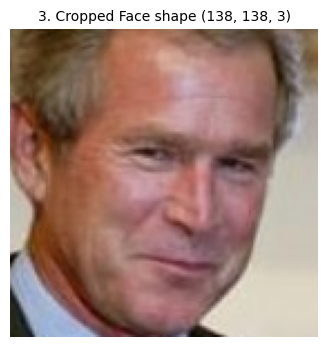

Face detection and cropping completed. Total 480 files


In [23]:
# OFFLINE - Detect Face and Cropp the images
if not CROPPED_DS_PATH.exists():
  CROPPED_DS_PATH.mkdir(exist_ok=True)  # Make dataset directory
  h, w, channels = ORIGINAL_IMAGE_SIZE
  show_first_images = 3
  show_image = True

  # Disable progress bar
  tf.keras.utils.disable_interactive_logging()

  for file_path in ds.file_paths:
      label = Path(file_path).parent.name
      file_name = Path(file_path).name

      cropped_class_path = Path(CROPPED_DS_PATH, label)
      cropped_file_path = Path(cropped_class_path, file_name)

      if not cropped_file_path.exists():
          # Show some first images
          if show_first_images > 0:
              show_first_images -= 1
          else:
              show_image = False

          # Read the image
          img_bytes = tf.io.read_file(file_path)
          image = tf.image.decode_jpeg(img_bytes, channels=channels)

          # ---------------
          # Face Detection
          # ---------------
          image = face_detection(image.numpy(), show=show_image)
          show_first_image = False

          # ---------------
          # Resize Image
          # ---------------
          image = image_resize(image)

          # Save the image
          image = tf.image.convert_image_dtype(image, tf.uint8)
          image_bytes = tf.image.encode_jpeg(image)
          tf.io.write_file(str(cropped_file_path), image_bytes)

  # Enable progress bar
  tf.keras.utils.enable_interactive_logging()

print(f"Face detection and cropping completed. Total {ds.cardinality().numpy()} files")

## 3.4 Online Preprocessing

### 3.4.1 Image Augmentation Layer

In [24]:
# Build Augmentation layer with following actions:
# - Random Flipping
# - Random Rotation
# - Random Zoom
def build_augmentation_layer(image_size=IMAGE_SIZE):
    input_image = layers.Input(shape=image_size, name="input-image")

    img = layers.RandomFlip("horizontal")(input_image)
    img = layers.RandomRotation(0.1)(img)
    output_image = layers.RandomZoom(0.1)(img)

    model = Model(inputs=[input_image], outputs=output_image)
    return model

In [25]:
# Create object of Augmentation layer
ImageAugmentation = build_augmentation_layer()

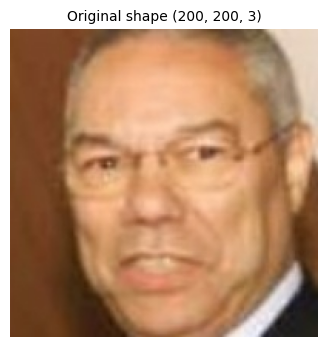

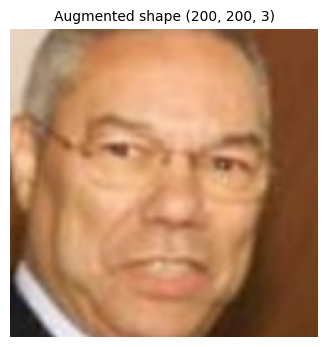

In [26]:
# [DEBUG] Test image augmentation
_file_name = np.random.choice(list(CROPPED_DS_PATH.glob("*/*")))
_img_bytes = tf.io.read_file(str(_file_name))
_image = tf.image.decode_jpeg(_img_bytes, channels=C)

show_sample(_image, "Original")
_image = ImageAugmentation(tf.expand_dims(_image, axis=0))
show_sample(tf.cast(_image, tf.uint8), "Augmented")

### 3.4.2 Image Normalization (Rescale)

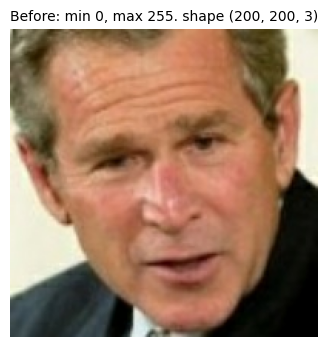

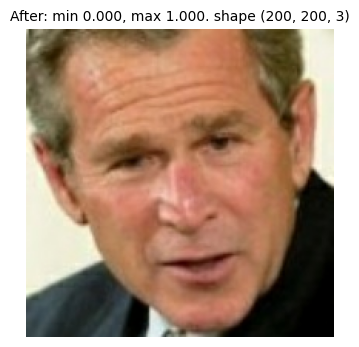

In [27]:
# [DEBUG] Test image rescaling
_file_name = np.random.choice(list(CROPPED_DS_PATH.glob("*/*")))
_img_bytes = tf.io.read_file(str(_file_name))
_image = tf.image.decode_jpeg(_img_bytes, channels=C)

show_sample(
    _image,
    f"Before: min {_image.numpy().min()}, max {_image.numpy().max()}.",
)

# Rescale Layer
_image_out = layers.Rescaling(1.0 / 255)(tf.expand_dims(_image, axis=0))
show_sample(
    _image_out,
    f"After: min {_image_out.numpy().min():.3f}, max {_image_out.numpy().max():.3f}.",
)

### 3.4.3 Put all online preprocessing together

In [28]:
@tf.function(reduce_retracing=True)
def load_image(file_path):
    # Load image from disk
    image_bytes = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image_bytes, channels=C)
    image = tf.cast(image, tf.float32)
    return image

In [29]:
def preprocess_image(image):
    """
    NOTE:
    Because of the ResNet preprocess_input() function,
    we can't use the Rescaling and Augmentation Layers.
    """
    return resnet.preprocess_input(image)

MIN with resnet is -123.68000030517578, MAX 150.06100463867188


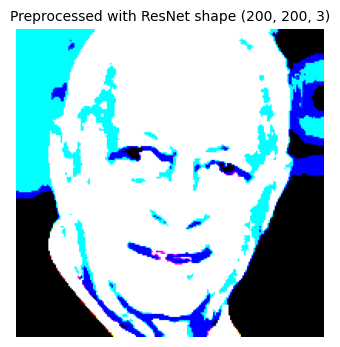

In [30]:
# [DEBUG] Test image preprocessing
_file_name = np.random.choice(list(CROPPED_DS_PATH.glob("*/*")))
_image = load_image(str(_file_name))
_image = preprocess_image(_image)
print(f"MIN with resnet is {tf.reduce_min(_image)}, MAX {tf.reduce_max(_image)}")
show_sample(_image, "Preprocessed with ResNet")

# 4. Classifier Implementation

## 4.1. DataSet Preparation

In [31]:
# Create DataSet object with cropped images
ds = preprocessing.image_dataset_from_directory(
    str(CROPPED_DS_PATH),
    label_mode="int",
    batch_size=None,
    image_size=(200, 200),
    shuffle=True,
    seed=RANDOM_SEED,
)

ds = ds.map(lambda X, y: (preprocess_image(X), y))
ds.element_spec

Found 480 files belonging to 8 classes.


(TensorSpec(shape=(200, 200, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [32]:
# Split our dataset in train, validation and test.
train_size = round(num_of_samples * TRAINING_PERCENTAGE)
train_ds = ds.take(train_size)
train_ds = train_ds.shuffle(buffer_size=1024, reshuffle_each_iteration=True)
print(f"Training Dataset size is {train_ds.cardinality().numpy()} samples")
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=False).prefetch(tf.data.AUTOTUNE)

val_size = round(num_of_samples * VALIDATION_PERCENTAGE)
val_ds = ds.skip(train_size).take(val_size)
val_ds = val_ds.shuffle(buffer_size=1024, reshuffle_each_iteration=True)
print(f"Validation Dataset size is {val_ds.cardinality().numpy()} samples")
val_ds = val_ds.batch(BATCH_SIZE, drop_remainder=False).prefetch(tf.data.AUTOTUNE)

test_ds = ds.skip(train_size).skip(val_size)
test_ds = test_ds.shuffle(buffer_size=1024, reshuffle_each_iteration=True)
print(f"Test Dataset size is {test_ds.cardinality().numpy()} samples.")
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=False).prefetch(tf.data.AUTOTUNE)

Training Dataset size is 288 samples
Validation Dataset size is 96 samples
Test Dataset size is 96 samples.


## 4.2 Modeling

### 4.2.1 Build Model

In [33]:
# Build Model Architecture
def build_classification_model(
    fc_neurons=1024, dropout_rate=DROPOUT_RATE, learning_rate=LEARNING_RATE, num_classes=num_of_classes
):

    pretrained_model = resnet.ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=(200, 200, 3),
    )
    # Freeze the pretrained model
    pretrained_model.trainable = False

    # Model Architecture
    input = layers.Input(shape=(200, 200, 3), name="input-image")

    if WITH_AUGMENTATION == True:
        x = ImageAugmentation(input)
    else:
        x = input

    x = pretrained_model(x)
    x = layers.Flatten(name="flatten")(x)
    x = layers.Dense(fc_neurons, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    output = layers.Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=input, outputs=output, name="classifier")

    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


classification_model = build_classification_model()
classification_model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input-image (InputLayer)    [(None, 200, 200, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense_7 (Dense)             (None, 1024)              102761472 
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 8)                 8200      
                                                         

In [34]:
# Plot the Model
tf.keras.utils.plot_model(
    classification_model,
    to_file="classification_model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    expand_nested=True,
    show_layer_activations=False,
    show_trainable=True,
)

Output hidden; open in https://colab.research.google.com to view.

### 4.2.2 Train Model

In [35]:
train_info = classification_model.fit(
    train_ds, validation_data=val_ds, epochs=TRAINING_EPOCHS
)
train_info.history

Epoch 1/10
9/9 [==============================] - 8s 244ms/step - loss: 6.6673 - accuracy: 0.3472 - val_loss: 2.3734 - val_accuracy: 0.8021
Epoch 2/10
9/9 [==============================] - 2s 119ms/step - loss: 0.9959 - accuracy: 0.8264 - val_loss: 0.5419 - val_accuracy: 0.8646
Epoch 3/10
9/9 [==============================] - 2s 117ms/step - loss: 0.3024 - accuracy: 0.8958 - val_loss: 0.2425 - val_accuracy: 0.9271
Epoch 4/10
9/9 [==============================] - 2s 116ms/step - loss: 0.1467 - accuracy: 0.9410 - val_loss: 0.0303 - val_accuracy: 0.9896
Epoch 5/10
9/9 [==============================] - 2s 121ms/step - loss: 0.0657 - accuracy: 0.9792 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 6/10
9/9 [==============================] - 2s 114ms/step - loss: 0.0340 - accuracy: 0.9931 - val_loss: 0.0904 - val_accuracy: 0.9896
Epoch 7/10
9/9 [==============================] - 2s 112ms/step - loss: 0.0410 - accuracy: 0.9965 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 8/10
9/9 [====

{'loss': [6.66727876663208,
  0.9959099888801575,
  0.30242273211479187,
  0.1467006653547287,
  0.06572538614273071,
  0.03395039215683937,
  0.04102778434753418,
  0.003551576752215624,
  0.0042045703157782555,
  0.0008441942627541721],
 'accuracy': [0.3472222089767456,
  0.8263888955116272,
  0.8958333134651184,
  0.9409722089767456,
  0.9791666865348816,
  0.9930555820465088,
  0.9965277910232544,
  1.0,
  1.0,
  1.0],
 'val_loss': [2.3733699321746826,
  0.5419223308563232,
  0.24252253770828247,
  0.03033418394625187,
  0.005414087325334549,
  0.09042265266180038,
  0.006777286529541016,
  0.0057945698499679565,
  0.00028244798886589706,
  0.00010494638263480738],
 'val_accuracy': [0.8020833134651184,
  0.8645833134651184,
  0.9270833134651184,
  0.9895833134651184,
  1.0,
  0.9895833134651184,
  1.0,
  1.0,
  1.0,
  1.0]}

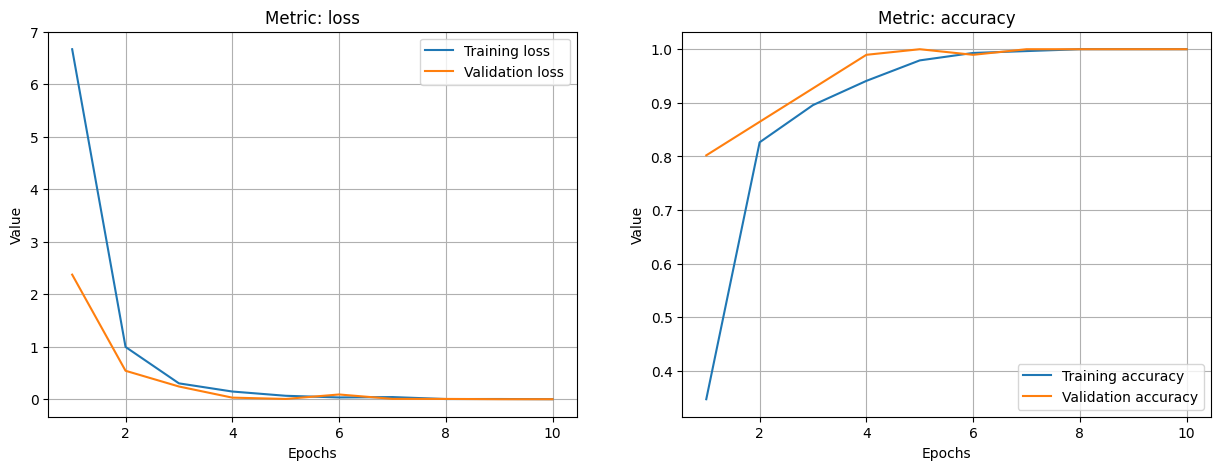

In [36]:
show_history(train_info.history)

### 4.2.3 Evaluate Model

In [37]:
# Evaluate the model
eval_info = classification_model.evaluate(test_ds)

# Show evaluation metrics
for metric_name, metric_val in zip(classification_model.metrics_names, eval_info):
    print(f"{metric_name}: {metric_val}")

eval_info

3/3 [==============================] - 1s 26ms/step - loss: 9.3555e-05 - accuracy: 1.0000
loss: 9.355463407700881e-05
accuracy: 1.0


[9.355463407700881e-05, 1.0]

### 4.2.4 Tuning Model Hyper-parameters

#### 4.2.4.1 Train Model with Different Params

In [38]:
class ClassifierHyperModel(kt.HyperModel):
    def build(self, hp):
        # Tune number of FC neurons
        hp_neurons = hp.Choice(
            "fc_neurons",
            values=[256, 512, 1024],
        )
        # Tune Dropout rate
        hp_dropout_rate = hp.Choice(
            "dropout_rate",
            values=[0.0, 0.3, 0.5],
        )
        # Tune the learning rate for the optimizer
        hp_learning_rate = hp.Choice(
            "learning_rate",
            values=[
                0.00001,
                0.0001,
                0.001
            ],
        )

        # New Classification Model
        model = build_classification_model(
            fc_neurons=hp_neurons,
            dropout_rate=hp_dropout_rate,
            learning_rate=hp_learning_rate,
        )

        return model

    def fit(self, hp, model, *args, **kwargs):
        batch_size = hp.Choice("batch_size", values=[32, 64])

        # Train the model
        train_ds = (
            kwargs["training_data"]
            .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
            .batch(batch_size, drop_remainder=False)
            .prefetch(tf.data.AUTOTUNE)
        )

        val_ds = (
            kwargs["validation_data"]
            .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
            .batch(batch_size, drop_remainder=False)
            .prefetch(tf.data.AUTOTUNE)
        )

        return model.fit(
            train_ds,
            validation_data=val_ds,
            shuffle=True,
            epochs=kwargs["epochs"],
        )

# Create a tuner object and perform hypertuning
tuner = kt.RandomSearch(
    ClassifierHyperModel(),
    objective="val_loss",
    overwrite=True,
    directory=PROJECT_PATH,
    project_name="classifier-tuning",
)

# Running the hyperparameter search.
tuner.search(
    training_data=train_ds.unbatch(),
    validation_data=val_ds.unbatch(),
    epochs=TRAINING_EPOCHS,
)

best_hps = tuner.get_best_hyperparameters(1)
best_hps[0].values

Trial 10 Complete [00h 00m 24s]
val_loss: 0.0017768001416698098

Best val_loss So Far: 0.00014212880341801792
Total elapsed time: 00h 03m 59s


{'fc_neurons': 1024,
 'dropout_rate': 0.0,
 'learning_rate': 0.001,
 'batch_size': 32}

In [39]:
best_learning_rate = best_hps[0].get("learning_rate")
best_batch_size = best_hps[0].get("batch_size")
best_fc_neurons = best_hps[0].get("fc_neurons")
best_dropout_rate = best_hps[0].get("dropout_rate")

#### 4.2.4.2 Retrain the Best Model

Epoch 1/10
9/9 [==============================] - 6s 273ms/step - loss: 108.0295 - accuracy: 0.2674 - val_loss: 34.3108 - val_accuracy: 0.5000
Epoch 2/10
9/9 [==============================] - 2s 121ms/step - loss: 13.8338 - accuracy: 0.6250 - val_loss: 4.8771 - val_accuracy: 0.7500
Epoch 3/10
9/9 [==============================] - 2s 115ms/step - loss: 2.6105 - accuracy: 0.8507 - val_loss: 1.1660 - val_accuracy: 0.8958
Epoch 4/10
9/9 [==============================] - 2s 124ms/step - loss: 0.5240 - accuracy: 0.9410 - val_loss: 0.1464 - val_accuracy: 0.9792
Epoch 5/10
9/9 [==============================] - 2s 126ms/step - loss: 0.2467 - accuracy: 0.9688 - val_loss: 0.1022 - val_accuracy: 0.9896
Epoch 6/10
9/9 [==============================] - 2s 116ms/step - loss: 0.0460 - accuracy: 0.9826 - val_loss: 0.1895 - val_accuracy: 0.9896
Epoch 7/10
9/9 [==============================] - 2s 121ms/step - loss: 2.9900e-04 - accuracy: 1.0000 - val_loss: 1.7352e-04 - val_accuracy: 1.0000
Epoch 8/

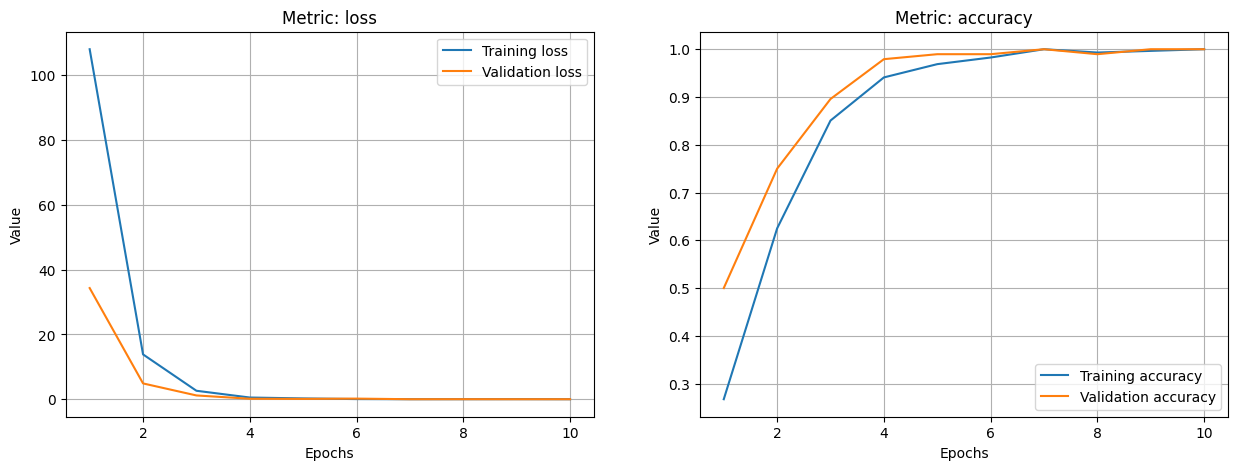

In [40]:
# Create a new model with the best hyper-parameters
best_classification_model = build_classification_model(
    fc_neurons=best_fc_neurons,
    dropout_rate=best_dropout_rate,
    learning_rate=best_learning_rate
)

train_ds = (
    train_ds.unbatch().shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .batch(best_batch_size, drop_remainder=False)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    val_ds.unbatch().shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .batch(best_batch_size, drop_remainder=False)
    .prefetch(tf.data.AUTOTUNE)
)

# Train the model
train_info = best_classification_model.fit(
    train_ds, validation_data=val_ds, shuffle=True, epochs=TRAINING_EPOCHS
)
show_history(train_info.history)

#### 4.2.4.3 Evaluate the Best Model

In [41]:
# Evaluate the model
eval_info = best_classification_model.evaluate(test_ds)

# Show evaluation metrics
for metric_name, metric_val in zip(best_classification_model.metrics_names, eval_info):
    print(f"{metric_name}: {metric_val}")

eval_info

3/3 [==============================] - 1s 26ms/step - loss: 5.8083e-04 - accuracy: 1.0000
loss: 0.000580830208491534
accuracy: 1.0


[0.000580830208491534, 1.0]

#### 4.2.4.4 Save the Best Model

In [42]:
# Save the Best Classifier
best_classification_model.save(str(CLASSIFICATION_MODEL_FILE))
del best_classification_model

In [43]:
# # Check it worked
best_classification_model = tf.keras.models.load_model(str(CLASSIFICATION_MODEL_FILE))

# Evalute the uploaded model
eval_info = best_classification_model.evaluate(test_ds)

for metric_name, metric_val in zip(best_classification_model.metrics_names, eval_info):
    print(f"{metric_name}: {metric_val}")
eval_info

3/3 [==============================] - 3s 29ms/step - loss: 5.2272e-04 - accuracy: 1.0000
loss: 0.0005227159708738327
accuracy: 1.0


[0.0005227159708738327, 1.0]

### 4.2.5 Test Model

In [44]:
acc = metrics.Accuracy()

# Take batch by batch from test_ds
for X, y_true in test_ds:
    y_pred = best_classification_model.predict(X, verbose=0)
    y_pred = tf.argmax(y_pred, axis=1)
    acc.update_state(y_true, y_pred)

print(f"Accuracy is {acc.result().numpy()}!")

Accuracy is 1.0!


## 4.3 Inference

In [45]:
def who_is_this(X_file, model=best_classification_model):
    X = load_image(X_file)
    X_prepr = preprocess_image(X)
    X_expand = tf.expand_dims(X_prepr, axis=0)
    y_preds = model.predict(X_expand, verbose=0)
    y_pred_id = tf.argmax(y_preds[0])
    y_pred_label = ds_class_names[y_pred_id.numpy()]

    return tf.cast(X, tf.uint8), y_pred_label

In [46]:
ds_class_names

['Ariel_Sharon',
 'Colin_Powell',
 'Donald_Rumsfeld',
 'George_W_Bush',
 'Gerhard_Schroeder',
 'Hugo_Chavez',
 'Junichiro_Koizumi',
 'Tony_Blair']

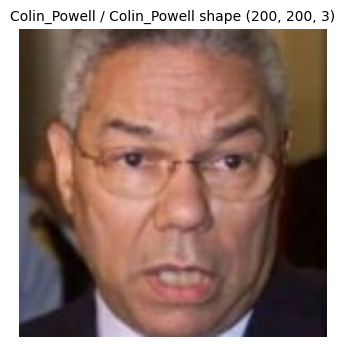

In [47]:
# Pick a random sample
test_sample_file = np.random.choice(list(CROPPED_DS_PATH.glob("*/*")))
y_true = test_sample_file.parent.name

X, y_pred = who_is_this(str(test_sample_file))
show_sample(X, f"{y_true} / {y_pred}")